# Process Affiliation

### Packages

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.collocations import *
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import collections
from collections import Counter
import networkx as nx
import time
import csv
import re

## Load data

In [2]:
md = pd.read_csv('mt_country/call_tpf.csv')
dpi = 300

### Conctruct index

In [3]:
code = ['JPN' , 'KOR', 'SGP', 'THA', 'MYS', 'VNM', 'IDN', 'PHL']
code2 = ['ALL'] + code 
code3 = ['ALL', 'SEA'] + code
code4 = ['SEA'] 
code5 = ['JPN' , 'KOR', 'SEA', 'SGP', 'THA', 'MYS', 'VNM', 'IDN', 'PHL']


all_idx = np.argwhere(np.array(md['Year'].astype(str).str.contains('20'))).T[0]
idn_idx = np.argwhere(np.array(md['IDN'])).T[0]
jpn_idx = np.argwhere(np.array(md['JPN'])).T[0]
kor_idx = np.argwhere(np.array(md['KOR'])).T[0]
sig_idx = np.argwhere(np.array(md['SGP'])).T[0]
phi_idx = np.argwhere(np.array(md['PHL'])).T[0]
mal_idx = np.argwhere(np.array(md['MYS'])).T[0]
tha_idx = np.argwhere(np.array(md['THA'])).T[0]
vie_idx = np.argwhere(np.array(md['VNM'])).T[0]
dd_idx = np.argwhere(np.array(md['JPN'] | md['KOR'])).T[0]
dm_idx = np.argwhere(np.array(md['SGP'] | md['THA'] | md['MYS'])).T[0]
dg_idx = np.argwhere(np.array(md['VNM'] | md['IDN'] | md['PHL'])).T[0]
sea_idx = np.argwhere(np.array(md['SGP'] | md['THA'] | md['MYS'] | md['VNM'] | md['IDN'] | md['PHL'])).T[0]

idx = [jpn_idx, kor_idx, sig_idx, tha_idx, mal_idx, vie_idx, idn_idx, phi_idx]
idx2 = [all_idx], idx
idx3 = [all_idx, sea_idx], idx
idx4 = [sea_idx], idx
idx5 = [jpn_idx, kor_idx, sea_idx, sig_idx, tha_idx, mal_idx, vie_idx, idn_idx, phi_idx]

mt = md.loc[all_idx, :]

In [4]:
## ADD ALL and SEA 

md['ALL'] = True
dtemp = md[['SGP', 'MYS', 'THA', 'VNM', 'IDN', 'PHL']]
dtemp = dtemp[dtemp.any(axis=1)]
idxlist = dtemp.index.tolist()
sea_bool = [bool(True) if f in idxlist else bool(False) for f in range(0,len(md)) ]
md['SEA'] = sea_bool

## Extract countries

In [5]:
# divide df according to db source

msy = mt[mt['Scopus']==1][['DOI_2', 'Affiliations']]
msn = mt[mt['Scopus']!=1][['DOI_2', 'Affiliations', 'Pubmed', 'Web of Science']]
msw = msn[msn['Affiliations'].str.startswith('[')==True][['DOI_2', 'Affiliations']]
msp = msn[msn['Affiliations'].str.startswith('[')==False][['DOI_2', 'Affiliations']]
print(len(msy), len(msw), len(msp))

19836 875 597


In [6]:
print(len(msy), len(msw), len(msp))

19836 875 597


In [7]:
#scopus

cl = []
for t in msy['Affiliations']:
    line = t.split('; ')
    cn = []
    for f in line:
        c = f.split(', ')[-1]
        cn.append(c)
    tl = ['United States' if 'United states' in f else f for f in cn]
    cl.append(tl)

msy['Countries'] = cl

In [8]:
#web of science

cln = []
for t in msw['Affiliations']:
    line = t.split('; [')
    cn = []
    for f in line:
        c = f.split(', ')[-1]
        cn.append(c)
    tl = ['United States' if 'USA' in f else f for f in cn]
    tl = ['United States' if 'United states' in f else f for f in tl]
    tl = ['United Kingdom' if 'UK' in f else f for f in tl]
    cln.append(tl)

msw['Countries'] = cln

In [9]:
#pubmed

msp['temp'] = msp['Affiliations'].str.replace('.;', ';')
msp['temp'] = msp['temp'].str.replace('. ', ', ')
msp['temp'] = msp['temp'].str.replace('.', '')

cl = []
for t in msp['temp']:
    line = t.split(';')
    cn = []
    for f in line:
        if '@' in f:
            c = f.split(', ')[-2]
        else: 
            c = f.split(', ')[-1]
        cn.append(c)
    tl = ['United States' if 'USA' in f else f for f in cn]
    tl = ['United States' if 'United states' in f else f for f in tl]
    tl = ['United Kingdom' if 'UK' in f else f for f in tl]
    cl.append(tl)
    
msp['Countries'] = cl
mspn = msp[['DOI_2', 'Affiliations', 'Countries']]

/tmp/ipykernel_3022/3340388156.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  msp['temp'] = msp['Affiliations'].str.replace('.;', ';')
/tmp/ipykernel_3022/3340388156.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  msp['temp'] = msp['temp'].str.replace('. ', ', ')
/tmp/ipykernel_3022/3340388156.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  msp['temp'] = msp['temp'].str.replace('.', '')


In [10]:
#Recombine

mdrc = pd.concat([msy, msw, mspn]).sort_index()

## Create separate dataframe

In [11]:
ctest = mdrc['Countries'].tolist()
cctest = [list(set(f)) for f in ctest]
dctest = md[list(code3)]
dctest['list'] = cctest

/tmp/ipykernel_3022/4237552851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dctest['list'] = cctest


In [12]:
code3

['ALL', 'SEA', 'JPN', 'KOR', 'SGP', 'THA', 'MYS', 'VNM', 'IDN', 'PHL']

In [19]:
ddcid = {}
for cid in code3: 
    dftest = dctest[dctest[cid] == True][[cid, 'list']]
    l = dftest['list'].tolist()
    lc = [f for f in l if len(f) == 1]
    ln = [f for f in l if len(f) > 1]
    ddcid[cid] = [len(dftest), len(lc), len(ln)]

dfcid = pd.DataFrame(ddcid)
dcid = dfcid.drop(columns = 'ALL')
dcid = dcid[list(code) + ['SEA']].T
dcid.columns = ['Total', 'Multi-country', 'Single-country']
dcid['Country-collaboration ratio'] = [f/n for f,n in zip(dcid['Multi-country'].tolist(), dcid['Total'].tolist())]
dcid

,Total,Multi-country,Single-country,Country-collaboration ratio
JPN,10519,6097,4422,0.579618
KOR,6671,4274,2397,0.640684
SGP,2044,382,1662,0.186888
THA,1201,349,852,0.290591
MYS,1087,412,675,0.379025
VNM,512,54,458,0.105469
IDN,441,96,345,0.217687
PHL,243,43,200,0.176955
SEA,5208,1336,3872,0.256528


In [17]:
code

['JPN', 'KOR', 'SGP', 'THA', 'MYS', 'VNM', 'IDN', 'PHL']

<function matplotlib.pyplot.show(close=None, block=None)>

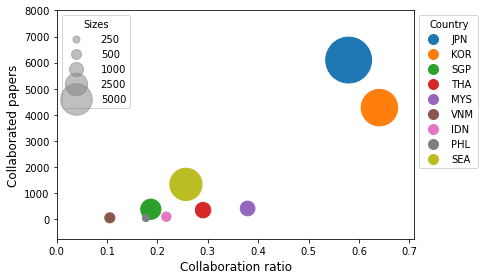

In [166]:
#with SEA

cdcolor = '#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22'

ax, fig = plt.subplots(figsize = (6,4))
#y = dcid['Total']
dcidn = pd.DataFrame({
        'Y': dcid['Multi-country'].tolist(),
        'X': dcid['Country-collaboration ratio'].tolist(),
#        'Colors': [ddcolor2[f] for f in list(doo.index)],
        "bubble_size" : [n/5 for n in dcid['Total'].tolist()]})
scatter = plt.scatter('X', 'Y',
             s='bubble_size',
            c=cdcolor,
             data=dcidn)
plt.xlim([0, 0.71])
plt.ylim(-750, 8000)

cdcode = dcid.index.tolist()

lines = []
for i,w in zip(cdcode, cdcolor):
    lines.append(Line2D([],[], label = w, color=w, markersize = 10, marker = 'o', lw=0))

legend1 = fig.legend(lines, cdcode, loc = 'upper left', bbox_to_anchor = (1,1),
                    frameon=True, title = 'Country')
fig.add_artist(legend1)

nvalue = [250, 500, 1000, 2500, 5000]
nsize = [f/5 for f in nvalue]

lines2 = []
for i,w in zip(nvalue, nsize):
    lines2.append(Line2D([],[], label = int(i), markersize=np.sqrt(w), 
                         color='grey', marker = 'o', lw=0, alpha = 0.5))
    
legend2 = fig.legend(lines2, nvalue, loc = 'upper left', labelspacing = 0.5,
                    frameon=True, title = 'Sizes', handletextpad = 1.5)

plt.xlabel('Collaboration ratio', size =12)
plt.ylabel('Collaborated papers', size =12)
plt.tight_layout() 
#plt.savefig('fig/lda_n/bub_coll.png', dpi=dpi, bbox_inches='tight')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

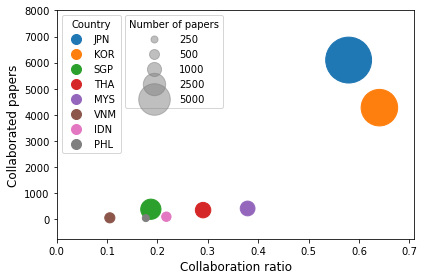

In [41]:
#only country 

#dcid = dcid.drop(index = 'SEA')
cdcolor = '#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F',

ax, fig = plt.subplots(figsize = (6,4))
#y = dcid['Total']
dcidn = pd.DataFrame({
        'Y': dcid['Multi-country'].tolist(),
        'X': dcid['Country-collaboration ratio'].tolist(),
#        'Colors': [ddcolor2[f] for f in list(doo.index)],
        "bubble_size" : [n/5 for n in dcid['Total'].tolist()]})
scatter = plt.scatter('X', 'Y',
             s='bubble_size',
            c=cdcolor,
             data=dcidn)
plt.xlim([0, 0.71])
plt.ylim(-750, 8000)

cdcode = dcid.index.tolist()

lines = []
for i,w in zip(cdcode, cdcolor):
    lines.append(Line2D([],[], label = w, color=w, markersize = 10, marker = 'o', lw=0))

legend1 = fig.legend(lines, cdcode, loc = 'upper left', 
                    frameon=True, title = 'Country', fontsize = 10)
fig.add_artist(legend1)

nvalue = [250, 500, 1000, 2500, 5000]
nsize = [f/5 for f in nvalue]

lines2 = []
for i,w in zip(nvalue, nsize):
    lines2.append(Line2D([],[], label = int(i), markersize=np.sqrt(w), 
                         color='grey', marker = 'o', lw=0, alpha = 0.5))
    
legend2 = fig.legend(lines2, nvalue, loc = 'lower right', bbox_to_anchor = (0.48, 0.55),
                    frameon=True, title = 'Number of papers', handletextpad = 1.5, fontsize = 10)

plt.xlabel('Collaboration ratio', size =12)
plt.ylabel('Collaborated papers', size =12)
plt.tight_layout() 
#plt.savefig('fig/lda_n/bub_collc.png', dpi=dpi, bbox_inches='tight')
plt.show

In [29]:
#Input data world bank

wb = pd.read_csv('rnd_exp/filtered_country.csv', sep=r'\,|\t', engine='python')
wbb = wb[['Country Code', 'IncomeGroup', 'Fill']]
wbl = [2,2,2,1,1,0,0,0]
wbb['IG'] = wbl
wbb

/tmp/ipykernel_3022/2628880180.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wbb['IG'] = wbl


,Country Code,IncomeGroup,Fill,IG
0,JPN,High income,3.27512,2
1,KOR,High income,4.52753,2
2,SGP,High income,1.92465,2
3,THA,Upper middle income,1.00179,1
4,MYS,Upper middle income,1.04086,1
5,VNM,Lower middle income,0.52674,0
6,IDN,Lower middle income,0.22633,0
7,PHL,Lower middle income,0.15683,0


<function matplotlib.pyplot.show(close=None, block=None)>

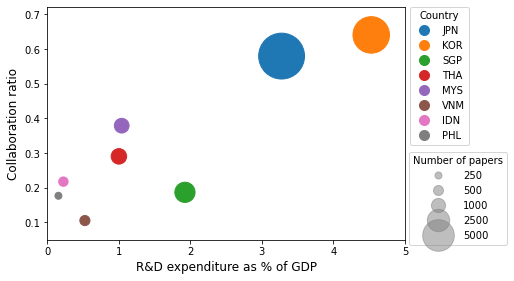

In [158]:
#only country 

cdcolor = '#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F',

ax, fig = plt.subplots(figsize = (7.5,4))
#y = dcid['Total']
dcidn = pd.DataFrame({
        'X': wbb['Fill'].tolist(),
        'Y': dcid['Country-collaboration ratio'].tolist(),
#        'Colors': [ddcolor2[f] for f in list(doo.index)],
        "bubble_size" : [n/5 for n in dcid['Total'].tolist()]})
scatter = plt.scatter('X', 'Y',
             s='bubble_size',
            c=cdcolor,
             data=dcidn)
plt.xlim([0, 5])
plt.ylim(0.05, 0.72)
#plt.yscale('log')

cdcode = dcid.index.tolist()

lines = []
for i,w in zip(cdcode, cdcolor):
    lines.append(Line2D([],[], label = w, color=w, markersize = 10, marker = 'o', lw=0))

legend1 = fig.legend(lines, cdcode, frameon=True, title = 'Country', fontsize = 10, 
                    bbox_to_anchor = (1,1.025))
fig.add_artist(legend1)

nvalue = [250, 500, 1000, 2500, 5000]
nsize = [f/5 for f in nvalue]

lines2 = []
for i,w in zip(nvalue, nsize):
    lines2.append(Line2D([],[], label = int(i), markersize=np.sqrt(w), 
                         color='grey', marker = 'o', lw=0, alpha = 0.5))
    
legend2 = fig.legend(lines2, nvalue, frameon=True, title = 'Number of papers', handletextpad = 1.5, fontsize = 10, 
                    bbox_to_anchor = (1.3,0.4))

plt.xlabel('R&D expenditure as % of GDP', size =12)
plt.ylabel('Collaboration ratio', size =12)
plt.tight_layout() 
plt.savefig('fig/lda_n/bub_rc.png', dpi=dpi, bbox_inches='tight')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

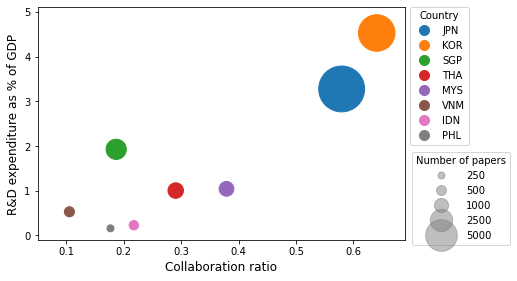

In [159]:
#Only country 

cdcolor = '#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F',

ax, fig = plt.subplots(figsize = (7.5,4))
#y = dcid['Total']
dcidn = pd.DataFrame({
        'Y': wbb['Fill'].tolist(),
        'X': dcid['Country-collaboration ratio'].tolist(),
#        'Colors': [ddcolor2[f] for f in list(doo.index)],
        "bubble_size" : [n/5 for n in dcid['Total'].tolist()]})
scatter = plt.scatter('X', 'Y',
             s='bubble_size',
            c=cdcolor,
             data=dcidn)
plt.ylim([-0.1, 5.1])
plt.xlim(0.05, 0.69)
#plt.yscale('log')

cdcode = dcid.index.tolist()

lines = []
for i,w in zip(cdcode, cdcolor):
    lines.append(Line2D([],[], label = w, color=w, markersize = 10, marker = 'o', lw=0))

legend1 = fig.legend(lines, cdcode, frameon=True, title = 'Country', fontsize = 10, 
                    bbox_to_anchor = (1,1.025))
fig.add_artist(legend1)

nvalue = [250, 500, 1000, 2500, 5000]
nsize = [f/5 for f in nvalue]

lines2 = []
for i,w in zip(nvalue, nsize):
    lines2.append(Line2D([],[], label = int(i), markersize=np.sqrt(w), 
                         color='grey', marker = 'o', lw=0, alpha = 0.5))
    
legend2 = fig.legend(lines2, nvalue, frameon=True, title = 'Number of papers', handletextpad = 1.5, fontsize = 10, 
                    bbox_to_anchor = (1.3,0.4))

plt.xlabel('Collaboration ratio', size =12)
plt.ylabel('R&D expenditure as % of GDP', size =12)
plt.tight_layout() 
plt.savefig('fig/lda_n/bub_rci.png', dpi=dpi, bbox_inches='tight')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

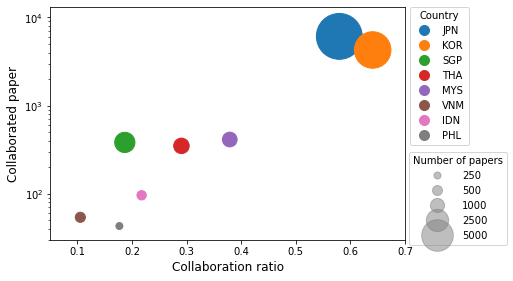

In [146]:
#only country 

cdcolor = '#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F',

ax, fig = plt.subplots(figsize = (7.5,4))
#y = dcid['Total']
dcidn = pd.DataFrame({
        'Y': dcid['Multi-country'].tolist(),
        'X': dcid['Country-collaboration ratio'].tolist(),
#        'Colors': [ddcolor2[f] for f in list(doo.index)],
        "bubble_size" : [n/5 for n in dcid['Total'].tolist()]})
scatter = plt.scatter('X', 'Y',
             s='bubble_size',
            c=cdcolor,
             data=dcidn)
plt.xlim([0.05, 0.7])
plt.ylim(30, 13000)
plt.yscale(value='log')


cdcode = dcid.index.tolist()

lines = []
for i,w in zip(cdcode, cdcolor):
    lines.append(Line2D([],[], label = w, color=w, markersize = 10, marker = 'o', lw=0))

legend1 = fig.legend(lines, cdcode, frameon=True, title = 'Country', fontsize = 10, 
                    bbox_to_anchor = (1,1.025))
fig.add_artist(legend1)

nvalue = [250, 500, 1000, 2500, 5000]
nsize = [f/5 for f in nvalue]

lines2 = []
for i,w in zip(nvalue, nsize):
    lines2.append(Line2D([],[], label = int(i), markersize=np.sqrt(w), 
                         color='grey', marker = 'o', lw=0, alpha = 0.5))
    
legend2 = fig.legend(lines2, nvalue, frameon=True, title = 'Number of papers', handletextpad = 1.5, fontsize = 10, 
                    bbox_to_anchor = (1.3,0.4))

plt.xlabel('Collaboration ratio', size =12)
plt.ylabel('Collaborated paper', size =12)
plt.tight_layout() 
plt.savefig('fig/lda_n/bub_collp.png', dpi=dpi, bbox_inches='tight')
plt.show

## Create network

In [362]:
#Count double country name

import collections
from collections import Counter

ntest = [item for sublist in cctest for item in sublist]
counts = Counter(ntest)

In [469]:
dccount = pd.DataFrame(counts, index=[0]).T
dccount['no'] = list(range(0, len(dccount)))
dccount['country'] = dccount.index.tolist()
dccount = dccount.set_index('no')
dccount35 = dccount.sort_values(by = 0, ascending = False).head(25)
#dccount[dccount['country'].str.contains('Viet')]
t35 = dccount35['country'].tolist()

In [470]:
#Aggregate country name

str_ctest = [str(f) for f in cctest]
n = pd.DataFrame({'no' : list(range(0,len(cctest))), 'orig' : str_ctest})
n['edit'] = n.orig.apply(lambda x: ''.join(str(x)))
n['edit'] = n['edit'].str.replace('Peoples R China', 'China')
n['edit'] = n['edit'].str.replace('Korea', 'South Korea')
n['edit'] = n['edit'].str.replace('South Korea;', 'South Korea')
n['edit'] = n['edit'].str.replace('Vietnam', 'Viet Nam')
n['edit'] = n['edit'].str.replace('[', '')
n['edit'] = n['edit'].str.replace(']', '')
#n[n['edit'].str.contains('Vietnam')]

/tmp/ipykernel_3284/1538474755.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  n['edit'] = n['edit'].str.replace('[', '')
/tmp/ipykernel_3284/1538474755.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  n['edit'] = n['edit'].str.replace(']', '')


In [516]:
#Create country index

m = n[['no','edit']]
for f in t35:
    m[f] = m['edit'].str.contains(f)

m = m.loc[:, (m != False).any(axis=0)]
m = m.drop(columns = ['no','edit'])
m = m.astype(int)
m

,Japan,South Korea,United States,Singapore,China,United Kingdom,Thailand,Germany,Malaysia,Australia,...,Indonesia,Switzerland,Spain,India,Sweden,Taiwan,Denmark,Belgium,Philippines,Brazil
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21303,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21304,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21305,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21306,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [519]:
# Prepare for input network

v = m.T.dot(m)
v.values[np.tril(np.ones(v.shape)).astype(np.bool)] = 0
a = v.stack()
cf = 25
a = a[a > cf].rename_axis(('source', 'target')).reset_index(name='weight')
#a = a.rename_axis(('source', 'target')).reset_index(name='weight')
a

,source,target,weight
0,Japan,South Korea,255
1,Japan,United States,2023
2,Japan,Singapore,132
3,Japan,China,667
4,Japan,United Kingdom,616
...,...,...,...
227,India,Sweden,28
228,India,Brazil,26
229,Sweden,Denmark,75
230,Sweden,Belgium,45


AttributeError: 'list' object has no attribute 'items'

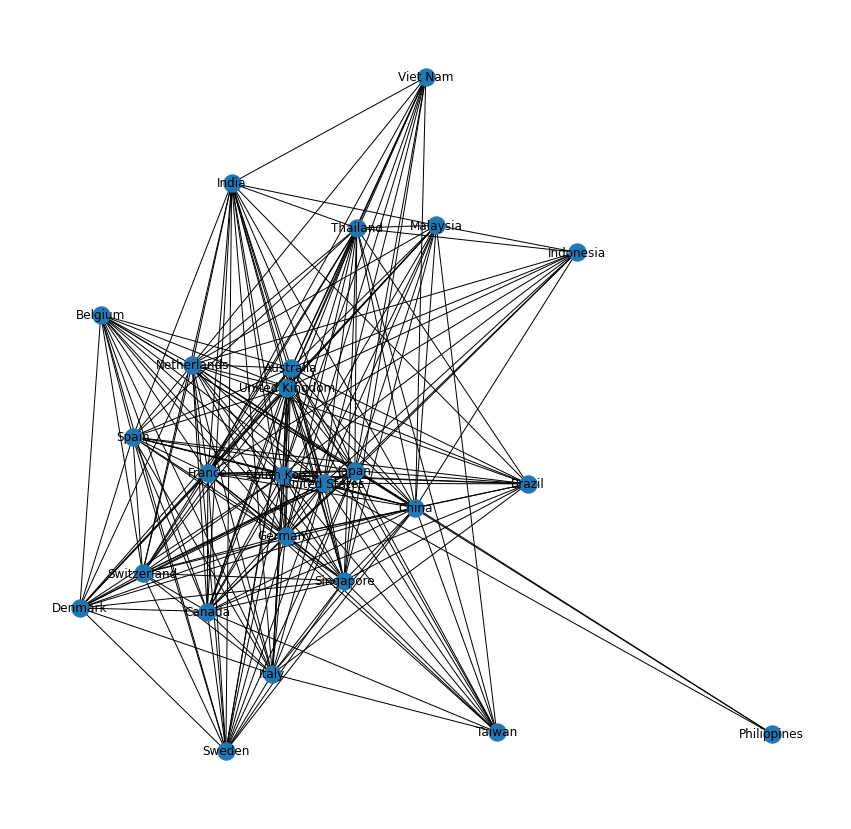

In [492]:
fig, ax = plt.subplots(figsize = (15,15))
G = nx.from_pandas_edgelist(a,  edge_attr=True)
nx.draw(G, with_labels = True)
pos = nx.spring_layout(G, seed=3113794652)
nx.draw_networkx_labels(G, pos, t30, font_size=22, font_color="whitesmoke")

## WorldBank data

In [11]:
wb = pd.read_csv('rnd_exp/filtered_country.csv', sep=r'\,|\t', engine='python')

In [13]:
wbb = wb[['Country Code', 'IncomeGroup', 'Fill']]
wbl = [2,2,2,1,1,0,0,0]
wbb['IG'] = wbl
wbb

/tmp/ipykernel_5435/688767929.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wbb['IG'] = wbl


,Country Code,IncomeGroup,Fill,IG
0,JPN,High income,3.27512,2
1,KOR,High income,4.52753,2
2,SGP,High income,1.92465,2
3,THA,Upper middle income,1.00179,1
4,MYS,Upper middle income,1.04086,1
5,VNM,Lower middle income,0.52674,0
6,IDN,Lower middle income,0.22633,0
7,PHL,Lower middle income,0.15683,0


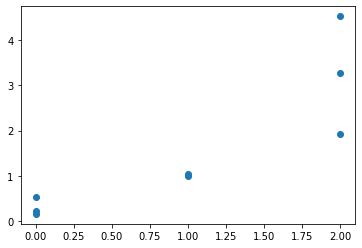

In [16]:
wbp = wbb.drop(columns = 'IncomeGroup')
plt.scatter('IG', 'Fill', data = wbp)

<AxesSubplot:>

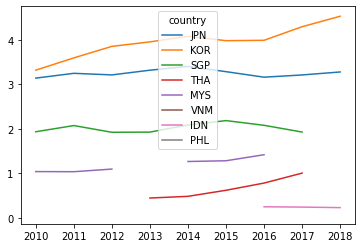

In [42]:
tl = list(range(2010, 2021))
tl = [str(f) for f in tl]
wbl = wbl[tl]
wbl['country'] = wb['Country Code'].tolist()
wbl = wbl.set_index('country')
wbl.T.plot()

In [36]:
code

NameError: name 'code' is not defined

In [295]:
msp['temp'] = msp['Affiliations'].str.replace('.;', ';')
msp['temp'] = msp['temp'].str.replace('. ', ', ')
msp['temp'] = msp['temp'].str.replace('.', '')

<ipython-input-295-e3c52ecab64f>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  msp['temp'] = msp['Affiliations'].str.replace('.;', ';')
<ipython-input-295-e3c52ecab64f>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  msp['temp'] = msp['temp'].str.replace('. ', ', ')
<ipython-input-295-e3c52ecab64f>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  msp['temp'] = msp['temp'].str.replace('.', '')


In [285]:
msp

,DOI_2,Affiliations,temp
10,10.1080/10715762.2019.1576867,a Department of Molecular Medicine and Biophar...,", Departmen, o, Molecula, Medicin, an, Biophar..."
53,10.1007/978-1-4939-7540-2_1,"Isotope Science Center, The University of Toky...","Isotop, Scienc, Center, Th, Universit, o, Toky..."
55,10.1016/j.molp.2017.09.013,"Biotechnology Research Institute, Chinese Acad...","Biotechnolog, Researc, Institute, Chines, Acad..."
66,10.1016/j.ajhg.2015.05.005,"Key Laboratory of Computational Biology, Max P...","Ke, Laborator, o, Computationa, Biology, Ma, P..."
91,10.4137/jcnsd.s23210,Department of Bioinformatics and Molecular Neu...,"Departmen, o, Bioinformatic, an, Molecula, Neu..."
...,...,...,...
21130,10.1667/rr14947.1,"Department of Molecular Biosciences, Radiation...","Departmen, o, Molecula, Biosciences, Radiatio,..."
21194,10.1093/nar/gky682,Department of Molecular Pharmacology and Exper...,"Departmen, o, Molecula, Pharmacolog, an, Exper..."
21250,10.1038/hgv.2015.50,"Department of Integrative Genomics, Tohoku Med...","Departmen, o, Integrativ, Genomics, Tohok, Med..."
21255,10.1007/978-1-0716-1036-7_9,"Artificial Intelligence Research Center, AIST,...","Artificia, Intelligenc, Researc, Center, AIST,..."


## Extract institute names

### Count affiliation items to decide determiner

In [ ]:
#Get affiliation items

md['PI'] = md['Affiliations'].str.replace('[^a-zA-Z0-9\' ]', ',')

md['PI'] = md['PI'].str.replace(';', ',')
md['PI'] = md['PI'].str.replace(', ', ',')
md['PI'] = md['PI'].str.replace(' ,', ',')
md['PI'] = md['PI'].str.replace(',,', ',')

md['PI'] = md['PI'].apply(lambda x: (re.split(r'[,]', x)))

afl = md['PI'].tolist()
afl2 = [item for sublist in afl for item in sublist]

In [ ]:
#Count affliation items
counts = Counter(afl2)
dafl = pd.DataFrame({'word' : list(counts.keys()), 'counts' : list(counts.values())})

In [ ]:
dafl = pd.DataFrame({'word' : list(counts.keys()), 'counts' : list(counts.values())})
dafil = dafl.sort_values(by= ['counts'], ascending = False)
#print(dafil.head(500)['word'].tolist())

In [ ]:
dafil.loc[(dafil['word'].str.contains('Korea') == True), :].head(50)

In [ ]:
text = md[md['Scopus']==1]['Affiliations'].tail(1).tolist()
text = str(text).replace('\']', '')
text = str(text).replace('[\'', '')
text.split(';')

In [ ]:
md[md['Abstract'].str.contains('neurosc')]

In [ ]:
test = dafl['word'].tolist()
fnn = [w for w in test if w.startswith('univ')]
fnn

### Extract affiliation

In [ ]:
ins = ['Univer', 'Instit', 'Cent']
md['PI'] = md['PI'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
ins = ['University', 'Institute']
test = mdf.head(10)
check = test['PI'].apply(lambda x: ', '.join([word for word in x.split(', ') if not any(tag in word for tag in ins)]))
check

In [ ]:
mdf['PI'].tolist()

In [ ]:
check

In [ ]:
md['Affiliations'][0]